In [ ]:
# Project 3 - Hurricane Harvey Neural Networks

# COE 379L  
# Ayushi Sapru / as98489

In [4]:
# Part 1: Data preprocessing and visualization

import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory

data_dir = "../coe379L-sp25/datasets/unit03/Project3"

from tensorflow.keras.utils import image_dataset_from_directory

# Load dataset and resize all images. 

dataset = image_dataset_from_directory(
    data_dir,
    labels = 'inferred',
    label_mode = 'binary',
    batch_size = 32,
    image_size = (128, 128),
    shuffle = True,
    seed = 42
)

# Output number of files and class names.

print("Class names: ", dataset.class_names)
print("Number of batches: ", tf.data.experimental.cardinality(dataset).numpy())

Found 21322 files belonging to 2 classes.
Class names:  ['damage', 'no_damage']
Number of batches:  667


2025-04-10 09:15:26.094295: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


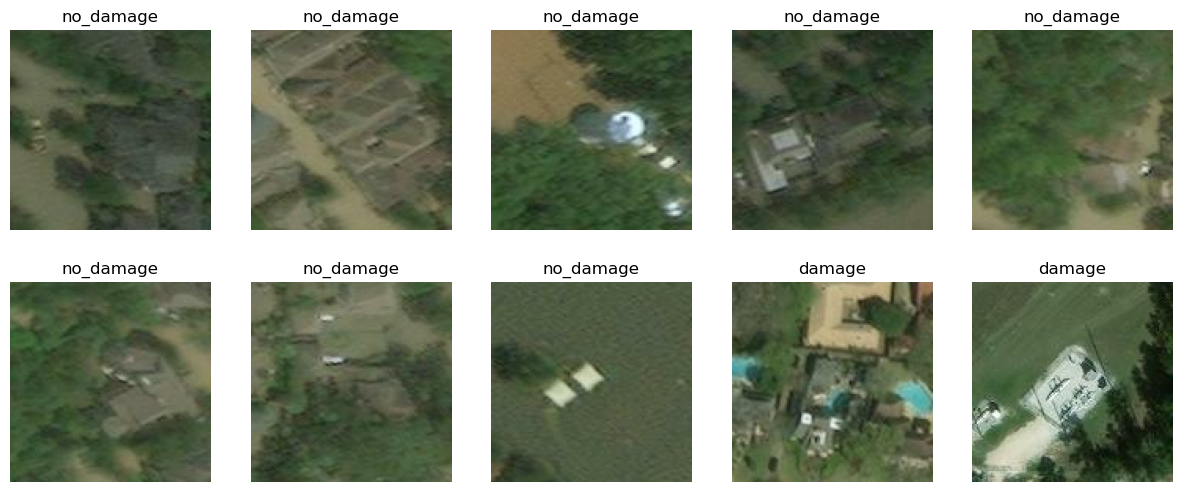

In [5]:
# Investigate the datasets to determine basic attributes of the images. 

# Visualize a batch of 10 images from the dataset and print. 

plt.figure(figsize = (15, 6))
for images, labels in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(2, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title("damage" if labels[i] == 1 else "no_damage")
        plt.axis("off")


In [7]:
# Check shape of a single image and data type info. Also, check labels to make sure they're binary.

total_batches = tf.data.experimental.cardinality(dataset).numpy()
total_images = total_batches * 32
print("Estimated total number of images:", total_images)

for images, labels in dataset.take(1):
    print("Shape of one image:", images[0].shape)   
    print("Data type of image:", images[0].dtype)
    print("Shape of one label:", labels[0].shape)
    print("Data type of label:", labels[0].dtype)
    break

Estimated total number of images: 21344
Shape of one image: (128, 128, 3)
Data type of image: <dtype: 'float32'>
Shape of one label: (1,)
Data type of label: <dtype: 'float32'>


In [8]:
# Count damaged and no_damage. 

import numpy as np
total_damage = 0
total_no_damage = 0

for _, labels in dataset:
    total_damage += np.sum(labels.numpy())
    total_no_damage += len(labels.numpy()) - np.sum(labels.numpy())

print("Total damage images: ", int(total_damage))
print("Total no_damage images: ", int(total_no_damage))

Total damage images:  7152
Total no_damage images:  14170


In [11]:
# Ensure data is split for training, validation and testing and perform any additional preprocessing (e.g., rescaling, normalization, etc.) so that it can be used for training/evaluation of the neural networks you will build in Part 2.

# Split into 80% train and 20% validation/test. 

img_size = (128, 128)
batch_size = 32

train_ds = image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size = img_size,
    batch_size = batch_size,
    label_mode = "binary"
)

valtest_ds = image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = img_size,
    batch_size = batch_size,
    label_mode = "binary"
)

# Split valtest_ds (20%) into final validation and test sets.
val_batches = tf.data.experimental.cardinality(valtest_ds) // 2
val_ds = valtest_ds.take(val_batches)
test_ds = valtest_ds.skip(val_batches)

# Normalize image pixels.
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))
test_ds = test_ds.map(lambda x, y: (normalization_layer(x), y))

# From CNN class lecture - TF will automatically figure out the optimal # of batches while the model is training. 
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(buffer_size = AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size = AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size = AUTOTUNE)


Found 21322 files belonging to 2 classes.
Using 17058 files for training.
Found 21322 files belonging to 2 classes.
Using 4264 files for validation.


In [12]:
# Part 2: Model design, training, and evaluation. 

# A dense (i.e., fully connected) ANN. 

from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall

# Build the ANN model (from ANN class lecture).
ann_model = models.Sequential([
    layers.Flatten(input_shape = (128, 128, 3)),
    layers.Dense(256, activation = 'relu'),
    layers.Dense(128, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')  
])

# Compile the model. 
ann_model.compile(
    optimizer = Adam(),
    loss = BinaryCrossentropy(),
    metrics = [BinaryAccuracy(), Precision(), Recall()]
)

ann_model.summary()

# Train the model.
history_ann = ann_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10  
)

/home/ubuntu/.local/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,583,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,616,193 (48.13 MB)

 Trainable params: 12,616,193 (48.13 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 47s 86ms/step - binary_accuracy: 0.6066 - loss: 1.5831 - precision: 0.4126 - recall: 0.3987 - val_binary_accuracy: 0.7057 - val_loss: 0.5748 - val_precision: 0.5619 - val_recall: 0.6734
Epoch 2/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 46s 87ms/step - binary_accuracy: 0.6961 - loss: 0.6264 - precision: 0.5585 - recall: 0.4361 - val_binary_accuracy: 0.3708 - val_loss: 1.1893 - val_precision: 0.3520 - val_recall: 0.9905
Epoch 3/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 46s 86ms/step - binary_accuracy: 0.7029 - loss: 0.5941 - precision: 0.5917 - recall: 0.3964 - val_binary_accuracy: 0.6908 - val_loss: 0.6043 - val_precision: 0.5400 - val_recall: 0.7507
Epoch 4/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 47s 87ms/step - binary_accuracy: 0.7214 - loss: 0.5702 - precision: 0.6344 - recall: 0.3987 - val_binary_accuracy: 0.7537 - val_loss: 0.5316 - val_precision: 0.7529 - val_recall: 0.4393
Epoch 5/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 46s 86ms/step - binary_accuracy: 0.7381 - loss: 0.5466 -

In [13]:
# Evaluate ANN on a test set. 

test_loss, test_accuracy, test_precision, test_recall = ann_model.evaluate(test_ds)

print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)
print("Test Precision: ", test_precision)
print("Test Recall: ", test_recall)

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - binary_accuracy: 0.7251 - loss: 0.5483 - precision: 0.5661 - recall: 0.7669
Test Loss:  0.5728210210800171
Test Accuracy:  0.7108490467071533
Test Precision:  0.547325074672699
Test Recall:  0.7546099424362183


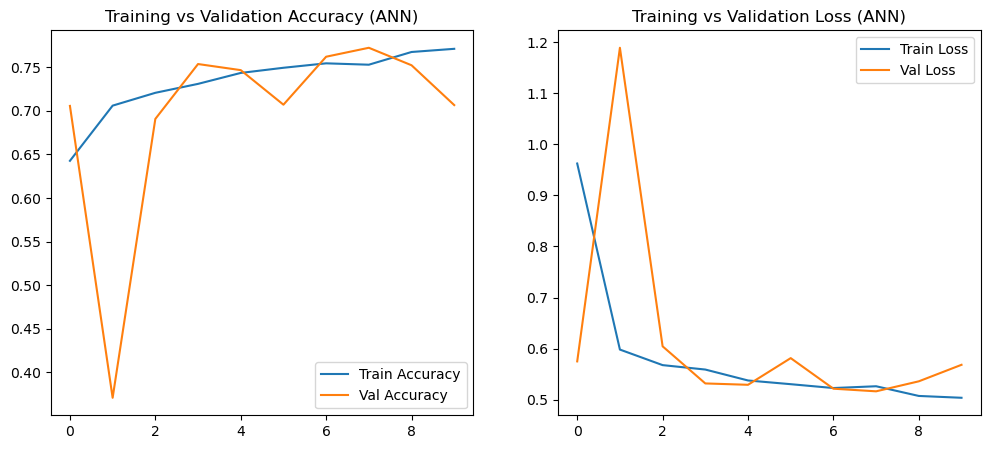

In [14]:
# Plot training vs validation accuracy and loss. 

acc = history_ann.history['binary_accuracy']
val_acc = history_ann.history['val_binary_accuracy']
loss = history_ann.history['loss']
val_loss = history_ann.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize = (12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label = 'Train Accuracy')
plt.plot(epochs_range, val_acc, label = 'Val Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training vs Validation Accuracy (ANN)')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label = 'Train Loss')
plt.plot(epochs_range, val_loss, label = 'Val Loss')
plt.legend(loc = 'upper right')
plt.title('Training vs Validation Loss (ANN)')
plt.show()

In [15]:
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = ann_model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend(preds.flatten())

# ChatGPT helped me write the below line to convert predictions to 0 or 1. 
y_pred_binary = [1 if p >= 0.5 else 0 for p in y_pred]

import sklearn.metrics as metrics
print(metrics.classification_report(y_true, y_pred_binary, target_names=["no_damage", "damage"]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

2025-04-10 09:27:04.994610: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
# ANN variant: add dropout + increase neurons

ann_model_v1 = models.Sequential([
    layers.Flatten(input_shape = (128, 128, 3)),
    layers.Dense(512, activation = 'relu'),
    layers.Dropout(0.5),
    layers.Dense(256, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

ann_model_v1.compile(
    optimizer = Adam(),
    loss = BinaryCrossentropy(),
    metrics = [BinaryAccuracy(), Precision(), Recall()]
)

ann_model_v1.summary()

history_ann_v1 = ann_model_v1.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10
)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │    25,166,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,297,921 (96.50 MB)

 Trainable params: 25,297,921 (96.50 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 86s 159ms/step - binary_accuracy: 0.6005 - loss: 2.1365 - precision_2: 0.3331 - recall_2: 0.1955 - val_binary_accuracy: 0.6502 - val_loss: 0.6478 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 2/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 142s 159ms/step - binary_accuracy: 0.6627 - loss: 0.6517 - precision_2: 0.3567 - recall_2: 0.0088 - val_binary_accuracy: 0.6567 - val_loss: 0.6437 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 3/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 85s 160ms/step - binary_accuracy: 0.6653 - loss: 0.6381 - precision_2: 0.0319 - recall_2: 9.7541e-05 - val_binary_accuracy: 0.6558 - val_loss: 0.6441 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 4/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 86s 160ms/step - binary_accuracy: 0.6659 - loss: 0.6380 - precision_2: 0.4130 - recall_2: 0.0039 - val_binary_accuracy: 0.6493 - val_loss: 0.6489 - val_precision_2: 0.0000e+00 - val_recall_2: 0.0000e+00
Epoch 5/10
534/534 ━━━━

In [18]:
print(metrics.classification_report(y_true, y_pred_binary, target_names=["no_damage", "damage"]))

              precision    recall  f1-score   support

   no_damage       0.85      0.69      0.76      1417
      damage       0.55      0.75      0.63       703

    accuracy                           0.71      2120
   macro avg       0.70      0.72      0.70      2120
weighted avg       0.75      0.71      0.72      2120



67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


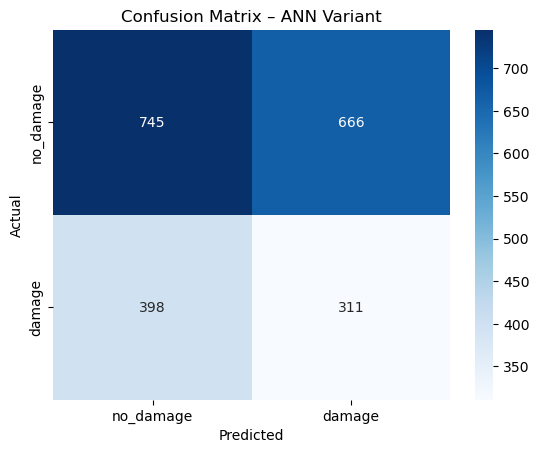

In [21]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_pred_ann = ann_model.predict(test_ds)
y_pred_binary_ann = (y_pred_ann > 0.5).astype("int32")

y_true_ann = np.concatenate([labels.numpy() for _, labels in test_ds])

cm_ann = confusion_matrix(y_true_ann, y_pred_binary_ann)
sns.heatmap(cm_ann, annot = True, fmt = "d", cmap = "Blues", xticklabels = ["no_damage", "damage"], yticklabels = ["no_damage", "damage"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix – ANN Variant")
plt.show()

In [22]:
# Now that we've created a variant of ANN with more neurons and added dropout, let's reanalyze. 
# The ANN variant successfully improved over the original model. However, it still misclassifies a notable number of images, especially confusing “damage” with “no_damage,” as seen in the confusion matrix.

In [24]:
# Evaluate Lenet-5 CNN. 

lenet_model = models.Sequential([
    layers.Conv2D(6, kernel_size = (5, 5), activation = 'relu', input_shape = (128, 128, 3)),
    layers.AveragePooling2D(pool_size=(2, 2)),
    layers.Conv2D(16, kernel_size = (5, 5), activation = 'relu'),
    layers.AveragePooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(120, activation = 'relu'),
    layers.Dense(84, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')  
])

# Compile
lenet_model.compile(
    optimizer = Adam(),
    loss = BinaryCrossentropy(),
    metrics = [BinaryAccuracy(), Precision(), Recall()]
)

lenet_model.summary()

# Train
history_lenet = lenet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 124, 124, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d               │ (None, 62, 62, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 58, 58, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_1             │ (None, 29, 29, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 13456)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 120)            │     1,614,840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 84)             │        10,164 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,627,961 (6.21 MB)

 Trainable params: 1,627,961 (6.21 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 55s 101ms/step - binary_accuracy: 0.7582 - loss: 0.5166 - precision_3: 0.6892 - recall_3: 0.4253 - val_binary_accuracy: 0.8988 - val_loss: 0.2857 - val_precision_3: 0.9108 - val_recall_3: 0.7883
Epoch 2/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 53s 100ms/step - binary_accuracy: 0.9048 - loss: 0.2624 - precision_3: 0.8997 - recall_3: 0.8051 - val_binary_accuracy: 0.8890 - val_loss: 0.2614 - val_precision_3: 0.8136 - val_recall_3: 0.8719
Epoch 3/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 54s 101ms/step - binary_accuracy: 0.9289 - loss: 0.1890 - precision_3: 0.9323 - recall_3: 0.8490 - val_binary_accuracy: 0.9207 - val_loss: 0.2084 - val_precision_3: 0.9331 - val_recall_3: 0.8297
Epoch 4/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 54s 100ms/step - binary_accuracy: 0.9421 - loss: 0.1539 - precision_3: 0.9488 - recall_3: 0.8739 - val_binary_accuracy: 0.8419 - val_loss: 0.4439 - val_precision_3: 0.6973 - val_recall_3: 0.9610
Epoch 5/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 54s 100ms/step - bin

In [25]:
test_loss, test_accuracy, test_precision, test_recall = lenet_model.evaluate(test_ds)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)

67/67 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - binary_accuracy: 0.9198 - loss: 0.3852 - precision_3: 0.9392 - recall_3: 0.8262
Test Loss: 0.348931223154068
Test Accuracy: 0.926886796951294
Test Precision: 0.9372056722640991
Test Recall: 0.8384831547737122


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━

2025-04-10 09:59:57.246039: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


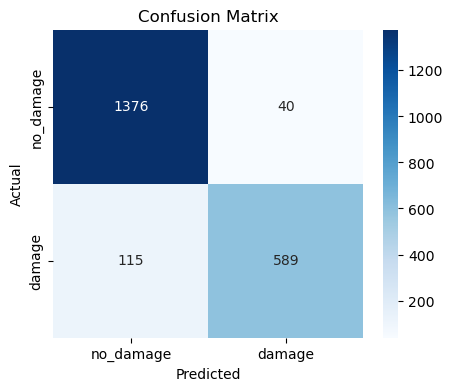

In [26]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

y_true = []
y_pred = []

for images, labels in test_ds:
    preds = lenet_model.predict(images)
    preds = (preds > 0.5).astype(int).flatten()
    y_pred.extend(preds)
    y_true.extend(labels.numpy().astype(int).flatten())

print(classification_report(y_true, y_pred, target_names=["no_damage", "damage"]))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize = (5,4))
# ChatGPT helped me write the below line - heat map. 
sns.heatmap(cm, annot = True, fmt = 'd', cmap = "Blues", xticklabels = ["no_damage", "damage"], yticklabels = ["no_damage", "damage"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [27]:
# Let's analyze. The LeNet 5 CNN architecture performed well on the classification task, with a test accuracy of 93, with a precision of 0.93 and recall of 0.90. 
# This is much stronger than the ANN model we ran above. Unlike the ANN model, LeNet 5 was able to conduct a balanced performance between both classes. 

In [28]:
# Alternate-Lenet-5 CNN architecture, described in the following link: https://arxiv.org/pdf/1807.01688.pdf.

alt_lenet_model = models.Sequential([
    layers.Conv2D(filters = 6, kernel_size = (5, 5), activation = 'relu', input_shape = (128, 128, 3)),
    layers.AveragePooling2D(pool_size = (2, 2)),

    layers.Conv2D(filters = 16, kernel_size = (5, 5), activation = 'relu'),
    layers.AveragePooling2D(pool_size = (2, 2)),

    layers.Conv2D(filters = 120, kernel_size = (5, 5), activation = 'relu'),

    layers.Flatten(),
    layers.Dense(84, activation = 'relu'),
    layers.Dense(1, activation = 'sigmoid')
])

# Compile
alt_lenet_model.compile(
    optimizer = Adam(),
    loss = BinaryCrossentropy(),
    metrics = [BinaryAccuracy(), Precision(), Recall()]
)

alt_lenet_model.summary()

# Train
history_alt_lenet = alt_lenet_model.fit(
    train_ds,
    validation_data = val_ds,
    epochs = 10
)

/home/ubuntu/.local/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 124, 124, 6)    │           456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_2             │ (None, 62, 62, 6)      │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 58, 58, 16)     │         2,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_3             │ (None, 29, 29, 16)     │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 120)    │        48,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 75000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 84)             │     6,300,084 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            85 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,351,161 (24.23 MB)

 Trainable params: 6,351,161 (24.23 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 74s 135ms/step - binary_accuracy: 0.7635 - loss: 0.4885 - precision_4: 0.6848 - recall_4: 0.5099 - val_binary_accuracy: 0.8829 - val_loss: 0.2772 - val_precision_4: 0.7946 - val_recall_4: 0.8973
Epoch 2/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 71s 133ms/step - binary_accuracy: 0.9102 - loss: 0.2375 - precision_4: 0.8888 - recall_4: 0.8370 - val_binary_accuracy: 0.9254 - val_loss: 0.1914 - val_precision_4: 0.9389 - val_recall_4: 0.8411
Epoch 3/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 72s 135ms/step - binary_accuracy: 0.9290 - loss: 0.1848 - precision_4: 0.9172 - recall_4: 0.8658 - val_binary_accuracy: 0.9380 - val_loss: 0.1731 - val_precision_4: 0.9513 - val_recall_4: 0.8656
Epoch 4/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 72s 135ms/step - binary_accuracy: 0.9376 - loss: 0.1633 - precision_4: 0.9313 - recall_4: 0.8783 - val_binary_accuracy: 0.9440 - val_loss: 0.1481 - val_precision_4: 0.9207 - val_recall_4: 0.9156
Epoch 5/10
534/534 ━━━━━━━━━━━━━━━━━━━━ 71s 134ms/step - bin

In [29]:
test_loss, test_accuracy, test_precision, test_recall = alt_lenet_model.evaluate(test_ds)

print("Test Loss: ", test_loss)
print("Test Accuracy: ", test_accuracy)
print("Test Precision: ", test_precision)
print("Test Recall: ", test_recall)

67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - binary_accuracy: 0.9456 - loss: 0.2309 - precision_4: 0.9363 - recall_4: 0.8960
Test Loss:  0.22486263513565063
Test Accuracy:  0.9462264180183411
Test Precision:  0.9297218322753906
Test Recall:  0.9058488011360168


67/67 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step
              precision    recall  f1-score   support

   no_damage       0.67      0.68      0.68      1412
      damage       0.34      0.33      0.33       708

    accuracy                           0.56      2120
   macro avg       0.50      0.50      0.50      2120
weighted avg       0.56      0.56      0.56      2120



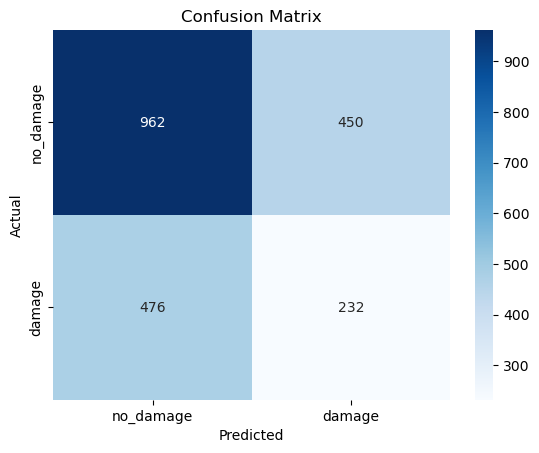

In [30]:
y_pred = alt_lenet_model.predict(test_ds)
y_pred_binary = (y_pred > 0.5).astype("int32")

y_true = np.concatenate([labels.numpy() for _, labels in test_ds])

print(classification_report(y_true, y_pred_binary, target_names=["no_damage", "damage"]))

cm = confusion_matrix(y_true, y_pred_binary)
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels = ["no_damage", "damage"], yticklabels = ["no_damage", "damage"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Let's analyze the Alternate LeNet 5 CNN model. This model did not perform as well as the standard LeNet 5.
# At first glance, the metrics seem promising, but the classification report and confusion matrix give us more insight: class imbalancing handling was poor - for the "damage" class, the precision was 0.32, recall was 0.31, and F1 0.31. And for "no_damage," precision, recall, and F1 were all 0.67. 
# Also, there were a high number of false negatives, which means a lot of "damage" images were misclassified as "no_damage."

In [31]:
# Now we can evaluate all the models and determine which performed the best.
# Lenet 5 had an accuracy of 93%. It proved to be the most balanced and reliable across both classes.
# ANN (variant version) had an accuracy of 67% and only predicted "no_damage." It was technically stable, but performed poorly on the minority class.
# Alternate LeNet 5 had an accuracy of 56%, performing the worst out of all the models. 

In [53]:
# Part 3: Model inference server and deployment

from tensorflow.keras.models import save_model

save_model(lenet_model, "lenet5_model.keras", save_format="keras")
